Datenvorbereitung
Definitionen von Armut, etc.
Klassifizierung der einzelnen Steps nach Crisp-DM

# Alle Datensätze sind unter folgenden Links zu finden:

GDP_per_capita_constant_dollar_2017
> http://data.un.org/Data.aspx?q=GDP+per+capita&d=WDI&f=Indicator_Code%3aNY.GDP.PCAP.PP.KD

infant_mortality_rate
> http://data.un.org/Data.aspx?q=infant+mortality+rate&d=PopDiv&f=variableID%3a77

life_expectancy
> http://data.un.org/Data.aspx?q=life+expectancy&d=PopDiv&f=variableID%3a68

natural_disasters
> https://www.kaggle.com/datasets/brsdincer/all-natural-disasters-19002021-eosdis/code

refugees_origin
> http://data.un.org/Data.aspx?q=refugees&d=UNHCR&f=indID%3aType-Ref

school_life_expextancy_ISCED_1-8
> http://data.un.org/Data.aspx?q=school+life&d=UNESCO&f=series%3aSLE_1T6

suicide_rates
> https://apps.who.int/gho/data/node.imr.MH_12?lang=en

total_fertility_rate
> http://data.un.org/Data.aspx?q=fertility+rate&d=PopDiv&f=variableID%3a54

total_population
> http://data.un.org/Data.aspx?q=population&d=PopDiv&f=variableID%3a12

WHR2021
> https://www.kaggle.com/datasets/ajaypalsinghlo/world-happiness-report-2021

# Weitere Quellen
Frageninspiration
> https://www.gapminder.org/

importieren Sie bitte folgende Bibliotheken :

- pip install pandas
- pip install matplotlib
- pip install numpy 
- pip install plotly 
- pip install seaborn 
- pip install scipy

In [104]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import plotly.express as px
import seaborn as sns

suicide_df = pd.DataFrame()
suicide_df = pd.read_csv('../data/suicide_rates.csv')

natural_disasters_df = pd.DataFrame()
natural_disasters_df = pd.read_csv('../data/natural_disasters.csv')

WHR2021_df = pd.DataFrame()
WHR2021_df = pd.read_csv('../data/WHR2021.csv')
WHR2021_df = WHR2021_df[['Country name', 'Ladder score']]
WHR2021_df.rename(columns={'Country name': 'Country or Area'}, inplace=True)
WHR2021_df.rename(columns={'Ladder Score': 'Value'}, inplace=True)


for column in suicide_df.columns[1:]:
    # Extract point estimates from entries in the column
    suicide_df[column] = suicide_df[column].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else x)

def process_csv_files(folder_path):
    # Get list of all CSV files in the folder

    files_to_exclude = ['natural_disasters.csv', 'WHR2021.csv']


    file_paths = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv') and file not in files_to_exclude:
            file_paths.append(os.path.join(folder_path, file))

    # List to store DataFrames
    dfs = []

    for file_path in file_paths:
        df = pd.read_csv(file_path)

        # Rename columns
        df.rename(columns={'Year(s)': 'Year', 'Time Period': 'Year', 'Reference Area': 'Country or Area',
                           'Observation Value': 'Value', 'Country or territory of origin': 'Country or Area',
                           'Refugees*': 'Value', 'Countries, territories and areas': 'Country or Area'},
                  inplace=True)

        # Filter out rows with year 2101
        df = df[df['Year'] != 2101]

        # Filter rows where 'Sex' column is 'all genders'
        if 'Sex' in df.columns:
            df = df[df['Sex'] == 'All genders']

        # Filter columns
        df = df[['Country or Area', 'Year', 'Value']]

        # Convert data types
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  # Convert to numeric, coerce errors to NaN
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')  # Convert to numeric, coerce errors to NaN

        # Extract the last part of the file path as the column suffix
        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Create custom column names
        custom_names = [f'{file_name}' if col == 'Value' else col for col in ['Country or Area', 'Year', 'Value']]

        # Rename columns
        df.columns = custom_names
        dfs.append(df)

    # Merge the DataFrames based on 'Country or Area' and 'Year'
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pd.merge(combined_df, df, on=['Country or Area', 'Year'], how='outer')

    # Regions to exclude
    regions_to_exclude = ['Africa', 'Asia', 'Australia/New Zealand', 'Australia/New Zealand', 'World', 'Eastern Africa',
                          'Eastern Africa', 'Eastern and South-Eastern Asia', 'Eastern Europe', 'High-income countries',
                          'Land-locked Developing Countries (LLDC)', 'Less developed regions, excluding China',
                          'Less developed regions',
                          'Less developed regions, excluding least developed countries',
                          'Small Island Developing States (SIDS)',
                          'No income group available', 'Northern Africa', 'Northern Africa and Western Asia',
                          'Northern America',
                          'Northern Europe', 'Low-income countries', 'Middle-income countries', 'More developed regions',
                          'Middle Africa',
                          'Eastern Asia', 'Soutern Asia', 'Western Europe', 'Upper-middle-income countries',
                          'Lower-middle-income countries',
                          'Europe', 'South-Eastern Asia', 'Southern Europe', 'Southern Asia', 'Southern Africa',
                          'Europe and Northern America',
                          'Central Asia', 'Central America', 'Central and Southern Asia', 'Sub-Saharan Africa',
                          'Least developed countries',
                          'Latin America and the Caribbean', 'Western Africa', 'South America', 'Western Asia']

    # Filter out regions
    filtered_combined_df = combined_df[~combined_df['Country or Area'].isin(regions_to_exclude)]

    filtered_combined_df.loc[:, "total_population"] *= 1000

    return filtered_combined_df

# Call the function with the folder path
folder_path = '../data'
result_df = process_csv_files(folder_path)

# Display the result DataFrame
display(result_df)
display(natural_disasters_df)
display(WHR2021_df)

,Country or Area,Year,refugees_origin,total_fertility_rate,school_life_expextancy_ISCED_1-8,total_population,suicide_rates,life_expectancy,infant_mortality_rate,GDP_per_capita_constant_dollar_2017
0,Afghanistan,1950,NaN,7.2484,NaN,7480461.0,NaN,27.7275,285.7875,NaN
1,Afghanistan,1951,NaN,7.2596,NaN,7571537.0,NaN,27.9634,283.5592,NaN
2,Afghanistan,1952,NaN,7.2601,NaN,7667533.0,NaN,28.4456,278.7896,NaN
3,Afghanistan,1953,NaN,7.2662,NaN,7764546.0,NaN,28.9304,273.9186,NaN
4,Afghanistan,1954,NaN,7.2542,NaN,7864285.0,NaN,29.2258,269.4016,NaN
...,...,...,...,...,...,...,...,...,...,...
139226,Zimbabwe,2096,NaN,1.9061,NaN,35469605.0,NaN,71.1427,18.3345,NaN
139227,Zimbabwe,2097,NaN,1.9011,NaN,35517791.0,NaN,71.2672,18.1935,NaN
139228,Zimbabwe,2098,NaN,1.8968,NaN,35561279.0,NaN,71.3869,18.0606,NaN
139229,Zimbabwe,2099,NaN,1.8890,NaN,35599779.0,NaN,71.4998,17.9413,NaN


,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16121,2021,449,FL-2021-000110,Natural,Hydrological,Flood,NaN,NaN,NaN,Yemen,...,67980.0,NaN,67980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16122,2021,75,NaN,Natural,Hydrological,Flood,NaN,NaN,NaN,South Africa,...,400.0,NaN,400.0,NaN,75000.0,NaN,1;2,2707;77311;77312;77313;77315,77364;77367,"Free State, KwaZulu-Natal, Limpopo, Mpumalanga..."
16123,2021,599,EP-2021-000138,Natural,Biological,Epidemic,Viral disease,NaN,Meningitis,Congo (the Democratic Republic of the),...,NaN,NaN,301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16124,2021,20,NaN,Natural,Hydrological,Flood,NaN,NaN,NaN,Serbia,...,22.0,NaN,22.0,NaN,NaN,NaN,1,25374;25378;25379;25380;25383;25386;25397,NaN,"Jablanicki, Kosovski, Kosovsko-mitrovatski, Ko..."


,Country or Area,Ladder score
0,Finland,7.842
1,Denmark,7.620
2,Switzerland,7.571
3,Iceland,7.554
4,Netherlands,7.464
...,...,...
144,Lesotho,3.512
145,Botswana,3.467
146,Rwanda,3.415
147,Zimbabwe,3.145


In [105]:
def visualize_suicide_rates_1(result_df):
    # Calculate average suicide rate across all countries for each year
    average_suicide_rate = result_df.groupby('Year')['suicide_rates'].mean()

    # Create a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(average_suicide_rate.index, average_suicide_rate.values, marker='o', linestyle='-')
    plt.title('Durchschnittliche Selbstmordrate über die Jahre')
    plt.xlabel('Jahr')
    plt.ylabel('Durchschnittliche Selbstmordrate')

    # Display the chart
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [106]:
def visualize_refugees_2(result_df):
    # Line Chart historisch
    # Filter data for the period from 1975 to 2021
    result_df_period = result_df[(result_df['Year'] >= 1975) & (result_df['Year'] <= 2021)]

    # Calculate the total number of refugees for each year
    total_refugees_per_year = result_df_period.groupby('Year')['refugees_origin'].sum()

    # Estimated world population for each year (Source: United Nations)
    world_population_per_year = {
        1975: 4.07e9, 1976: 4.13e9, 1977: 4.19e9, 1978: 4.25e9, 1979: 4.31e9,
        1980: 4.37e9, 1981: 4.43e9, 1982: 4.49e9, 1983: 4.55e9, 1984: 4.61e9,
        1985: 4.67e9, 1986: 4.73e9, 1987: 4.79e9, 1988: 4.85e9, 1989: 4.92e9,
        1990: 5.01e9, 1991: 5.11e9, 1992: 5.21e9, 1993: 5.31e9, 1994: 5.41e9,
        1995: 5.51e9, 1996: 5.61e9, 1997: 5.71e9, 1998: 5.81e9, 1999: 5.91e9,
        2000: 6.01e9, 2001: 6.11e9, 2002: 6.21e9, 2003: 6.31e9, 2004: 6.41e9,
        2005: 6.51e9, 2006: 6.61e9, 2007: 6.71e9, 2008: 6.81e9, 2009: 6.91e9,
        2010: 7.01e9, 2011: 7.11e9, 2012: 7.21e9, 2013: 7.31e9, 2014: 7.4e9,
        2015: 7.48e9, 2016: 7.55e9, 2017: 7.62e9, 2018: 7.68e9, 2019: 7.74e9,
        2020: 7.79e9, 2021: 7.84e9
    }

    # Calculate the percentage of refugees compared to the world population for each year
    percentage_refugees_per_year = (total_refugees_per_year / pd.Series(world_population_per_year)) * 100

    # Smooth the data using spline interpolation
    x_smooth = np.linspace(percentage_refugees_per_year.index.min(), percentage_refugees_per_year.index.max(), 300)
    y_smooth = make_interp_spline(percentage_refugees_per_year.index, percentage_refugees_per_year.values)(x_smooth)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(x_smooth, y_smooth, linestyle='-', color='blue')

    # Add data labels
    for year, percentage in zip(percentage_refugees_per_year.index, percentage_refugees_per_year.values):
        plt.text(year, percentage, f'{percentage:.2f}', ha='center', va='bottom', fontsize=8)

    plt.title('Percentage of World Population That Are Refugees (1975-2021)', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage of Refugees to World Population', fontsize=12)
    plt.grid(True)
    plt.xticks(range(1975, 2022, 2))
    plt.tight_layout()

In [107]:
def visualize_life_expectancy_3(df, year):
    # Filter data for the specified year
    df_year = df[df['Year'] == year]

    # Calculate overall range of life expectancy
    min_life_expectancy = df['life_expectancy'].min()
    max_life_expectancy = df['life_expectancy'].max()

    # Create figure using Plotly Express choropleth map
    fig = px.choropleth(df_year,
                        locations='Country or Area',
                        locationmode='country names',
                        color='life_expectancy',
                        hover_name='Country or Area',
                        title=f'Life Expectancy by Country ({year})',
                        color_continuous_scale='Viridis',
                        range_color=[min_life_expectancy, max_life_expectancy])
    fig.show()

In [108]:
def visualize_data_5(df, year):
    # Filter out countries/areas with a population under 1000
    df_filtered = df[df['total_population'] >= 10000]

    # Extract relevant columns
    fertility_rate = df_filtered['total_fertility_rate']
    infant_mortality_rate = df_filtered['infant_mortality_rate']
    total_population = df_filtered['total_population']
    gdp_per_capita = df_filtered['GDP_per_capita_constant_dollar_2017']  # Adding GDP per capita data

    # Calculate max values for scaling from the entire DataFrame
    max_fertility = df_filtered['total_fertility_rate'].max()
    max_infant_mortality = df_filtered['infant_mortality_rate'].max()
    max_total_population = df_filtered['total_population'].max()
    min_gdp_per_capita = df_filtered['GDP_per_capita_constant_dollar_2017'].min()
    max_gdp_per_capita = df_filtered['GDP_per_capita_constant_dollar_2017'].max()

    # Filter data for the specified year
    df_year = df_filtered[df_filtered['Year'] == year]

    # Extract relevant columns for the specified year
    fertility_rate_year = df_year['total_fertility_rate']
    infant_mortality_rate_year = df_year['infant_mortality_rate']
    total_population_year = df_year['total_population']
    gdp_per_capita_year = df_year['GDP_per_capita_constant_dollar_2017']

    # Calculate size of circles based on total population for the specified year
    circle_size_year = total_population_year / max_total_population * 500

    # Create figure using Plotly Express
    fig = px.scatter(df_year, x=fertility_rate_year, y=infant_mortality_rate_year, size=circle_size_year,
                     labels={'x': 'Fertility Rate', 'y': 'Infant Mortality Rate'},
                     title=f'Visualization of Fertility Rate vs Infant Mortality Rate ({year})',
                     size_max=30, hover_name=df_year['Country or Area'],
                     hover_data={'total_population': True, 'GDP_per_capita_constant_dollar_2017': True},  # Add GDP per capita to hover data
                     color=gdp_per_capita_year,  # Color based on GDP per capita for the specified year
                     color_continuous_scale='Inferno',  # Choose a color scale
                     range_color=[min_gdp_per_capita, max_gdp_per_capita])  # Set the range of color scale

    # Set x-axis and y-axis limits based on min and max values from entire DataFrame
    fig.update_xaxes(range=[0, max_fertility])
    fig.update_yaxes(range=[0, max_infant_mortality])

    # Dimension
    fig.update_layout(width=1024, height=512)

    fig.show()

In [109]:
def visualize_school_life_expectancy_6(df, year):
    # Filter data for the specified year
    df_year = df[df['Year'] == year]

    # Calculate overall range of life expectancy
    min_life_expectancy = df['school_life_expextancy_ISCED_1-8'].min()
    max_life_expectancy = df['school_life_expextancy_ISCED_1-8'].max()

    # Create figure using Plotly Express choropleth map
    fig = px.choropleth(df_year,
                        locations='Country or Area',
                        locationmode='country names',
                        color='school_life_expextancy_ISCED_1-8',
                        hover_name='Country or Area',
                        title=f'School Life Expectancy by Country ({year})',
                        color_continuous_scale='Viridis',
                        range_color=[min_life_expectancy, max_life_expectancy])
    fig.show()


In [110]:
def visualize_deaths_nature_7(natural_disasters_df):
    # Scatterplot + Regression
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))

    # Scatter plot
    sns.scatterplot(data=natural_disasters_df, x='Year', y='Total Deaths', color='blue', alpha=0.7)

    # Linear regression
    sns.regplot(data=natural_disasters_df, x='Year', y='Total Deaths', scatter=False, color='red', order=1, label='Linear')

    # Polynomial regression (order 2)
    sns.regplot(data=natural_disasters_df, x='Year', y='Total Deaths', scatter=False, color='green', order=2, label='Polynomial (Order 2)')

    # Polynomial regression (order 3)
    sns.regplot(data=natural_disasters_df, x='Year', y='Total Deaths', scatter=False, color='orange', order=3, label='Polynomial (Order 3)')

    # Polynomial regression (order 4)
    sns.regplot(data=natural_disasters_df, x='Year', y='Total Deaths', scatter=False, color='purple', order=4, label='Polynomial (Order 4)')

    plt.title('Natural Disaster Deaths Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Deaths')

    # Setting y-axis to logarithmic scale
    plt.yscale('log')

    plt.legend()  # Show legend with regression models
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

def visualize_happyness_8(gdp_df, happiness_df): #gdp_df = result_df, happiness_df = WHD_df
    
    gdp_df = gdp_df[['Country or Area', 'Year', 'GDP_per_capita_constant_dollar_2017']]
    year = 2021
    merged_df = pd.merge(gdp_df[gdp_df['Year'] == year], happiness_df, on='Country or Area')

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x='GDP_per_capita_constant_dollar_2017', y='Ladder score', data=merged_df)
    plt.xlabel('GDP per capita (constant $, 2017)')
    plt.ylabel('Happiness Score')
    plt.title(f'Correlation between GDP per capita and Happiness Score ({year})')
    plt.grid(True)
    plt.show()

1. Wie haben sich die globalen Selbstmordraten in den letzten x Jahren entwickelt? (Daten immer Schätzungen)

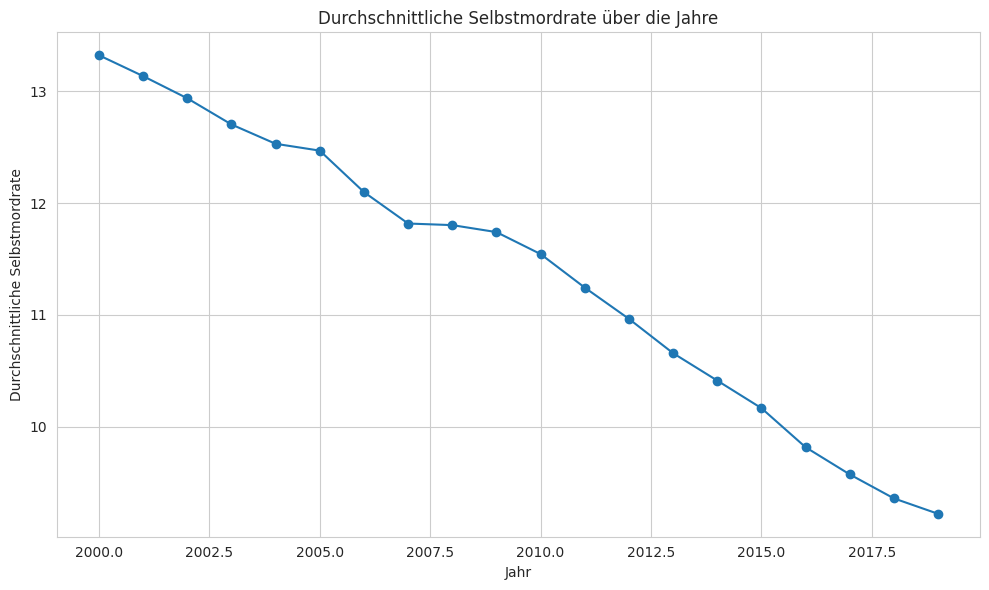

In [112]:
visualize_suicide_rates_1(result_df)

2. Wie viel Prozent der Weltbevölkerung sind Flüchtlinge?

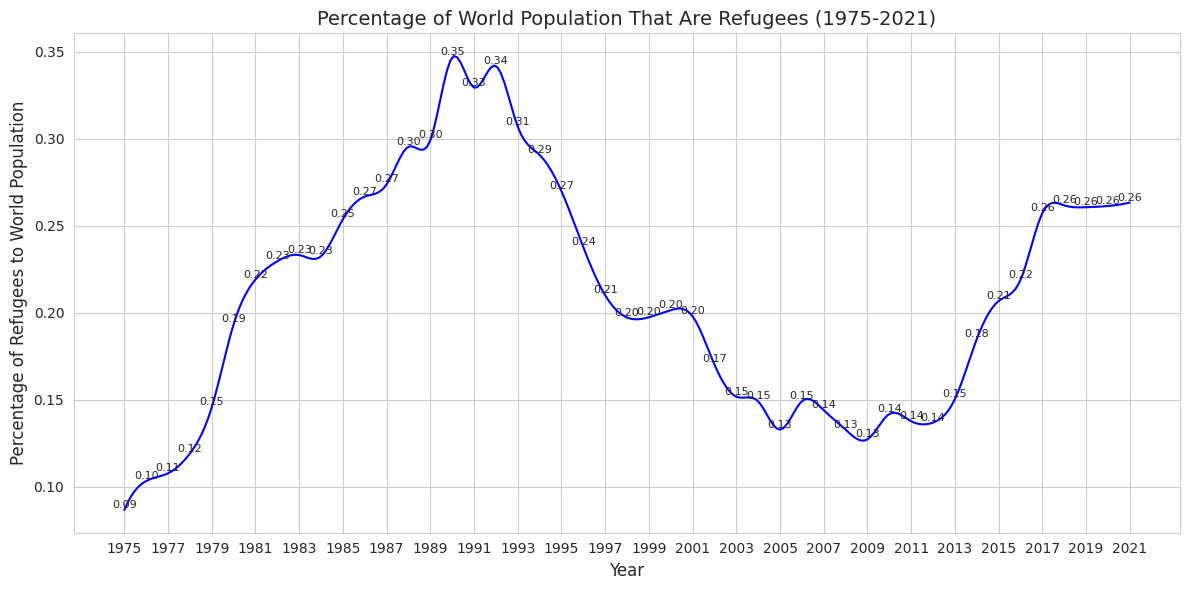

In [113]:
visualize_refugees_2(result_df)

3. Wie hat sich die Lebenserwartung global verändert?

In [114]:
visualize_life_expectancy_3(result_df, 2020)

4. Wie haben sich die Säuglingssterblich und die Geburtenrate (Primärfaktoren des HDI) historisch Entwickelt?

In [115]:
visualize_data_5(result_df, 2020)

5. Wie viele Jahre Schulbildung erhalten Kinder in unterschiedlichen Ländern?

In [116]:
visualize_school_life_expectancy_6(result_df, 2000)

6. Wie haben sich die Todesfälle durch Naturktastrophen in den letzten xx Jahren verändert?

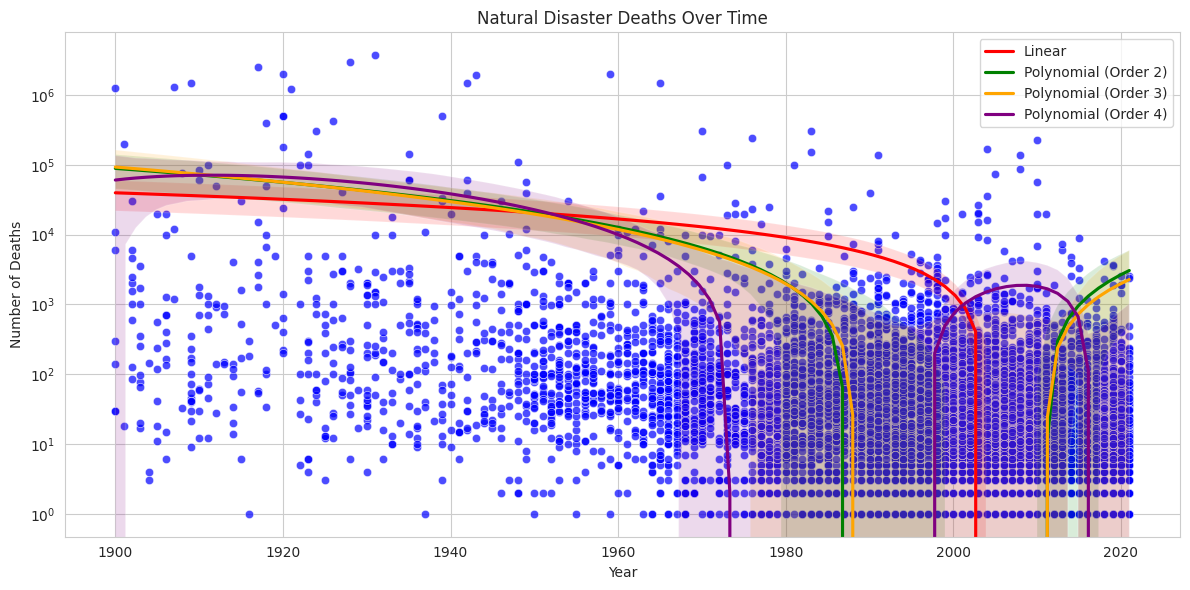

In [117]:
visualize_deaths_nature_7(natural_disasters_df)
# add Worldmap?

7. Inwieweit hängt das BIP mit der Glücklichkeit zusammen?

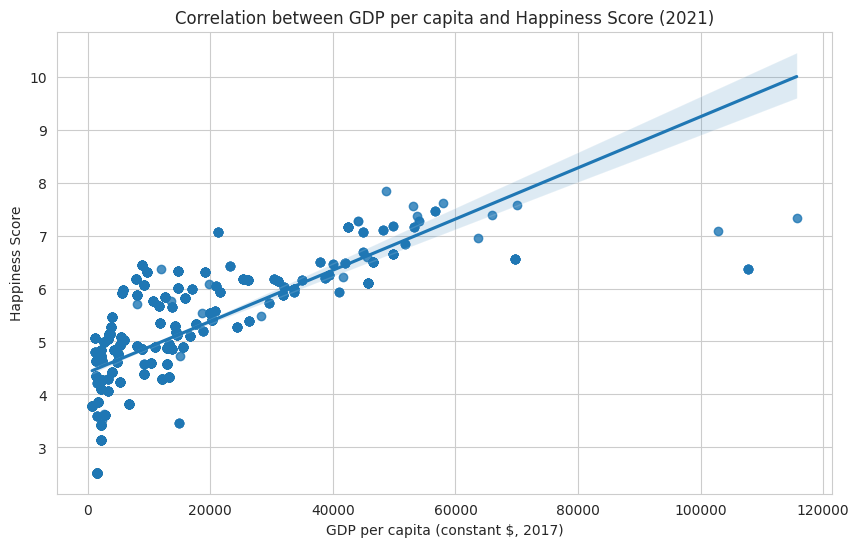

In [118]:
visualize_happyness_8(result_df, WHR2021_df)